# Customer Segmentation using unsupervised machine learning


## Introduction to the data

In this project we have customer behaviour data from a mobile app. The app connects users to different brands and provides offers from these brands. This app has three kinds of push notifications that it sends to its customers which is described below.

● “Watcher pushes” are sent when a publisher which the user followed (favorited) published a new brochure of offers

● “Geofence pushes” are sent when a user enters a geofence area of a store. i.e. radius of 100 m of an
electronics store.

● “Localytics pushes” are sent when a user is selected as part of a CRM campaign. The campaign is
sent on a time and on a day defined by the team.

It is safe to assume that: a notification is always sent whenever a notification is selected.


## Defining our approch to solving this problem

In this task we have a file with 84 columns and 100000 rows. Since the data consists of user behavior over a period of 8 weeks, we will stick to this timeline for our analysis i.e. we will get rid of the data column for last 30 days to maintain consistency in our data. Since there are multiple analyses that we can perform with this data, I have chosen to perform user segmentation to identify each user based on their behavior, after carefully examining the overall data. I made this decision in order to get to actionable insights that could easily lead to next strategic steps. Also, after the basic EDA, I suspect that the 8 weeks data might be distorting the overall trends due to seasonality effect. That is why user segmentation makes more sense in this case instead of looking at individual trends. 

To achieve this segmentation, I will utilise the unsupervised machine learning algorithm called K-means clustering. The steps that I will follow are summarised below:

1. Viewing the feature set in the file(formatting, column naming convention, etc.)
2. Basic Exploratory data Analysis to look at simple user behavior trends
3. Data pre-processing for the machine learning algorithm (imputing null values, calculating aggregates, etc.)
3. Employing k-means clustering to create clusters for certain aggregates for the last 8 weeks data
4. Use the clusters to calculate a user score that explains user behaviour for the last 8 weeks
5. Create segments using the user score
6. Articulate strategy per segment
7. Employ k-means algorithm again for the lifetime data per user to create clusters for each interaction type
8. Use the clusters to calculate a user score that explains user behaviour over lifetime
9. Create segments using the user score & compare these segments with the last 8 weeks segment
10. Articulate strategy per segment based on this comparison and the trends we observe


## Data importing & feature check

In [1]:
# importing the relevant modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# importing the csv into dataframes
df = pd.read_csv('ML_CS_data.csv')
df1 = pd.read_csv('ML_CS_data.csv')
# checking the file to see the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 84 columns):
app_starts_eight_weeks_ago                   45532 non-null float64
app_starts_five_weeks_ago                    43598 non-null float64
app_starts_four_weeks_ago                    43248 non-null float64
app_starts_last_30_days                      72249 non-null float64
app_starts_last_week                         39106 non-null float64
app_starts_seven_weeks_ago                   49150 non-null float64
app_starts_six_weeks_ago                     45603 non-null float64
app_starts_three_weeks_ago                   41476 non-null float64
app_starts_two_weeks_ago                     41896 non-null float64
geofence_pushes_opened_eight_weeks_ago       100000 non-null int64
geofence_pushes_opened_five_weeks_ago        100000 non-null int64
geofence_pushes_opened_four_weeks_ago        100000 non-null int64
geofence_pushes_opened_last_30_days          100000 non-null int64
geofence_p

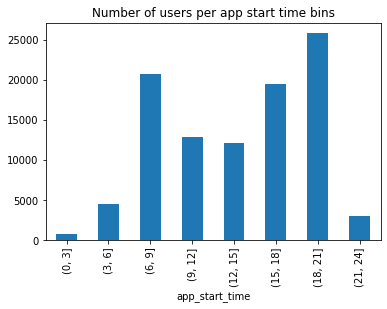

In [269]:
# Using the most popular app start hour to categorise users and create an over view
df['app_start_time'] = pd.cut(df.most_popular_app_start_hour,[0,3,6,9,12,15,18,21,24])
hour = df.groupby('app_start_time')['user_id'].count()
hour.plot(kind='bar')
plt.title('Number of users per app start time bins')
plt.show()

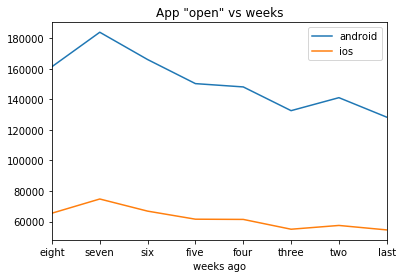

In [194]:
# Summarising the data and reformatting it to extract app start data
cols = list(df1.columns)

# diving columns for separate aggregation technique
cols.remove('user_platform_os')
cols.remove('user_id')
cols.remove('partition_brand')
uid = ['user_id']
d = {**dict.fromkeys(cols,'sum'),**dict.fromkeys(uid,'count')}

# Creating a summary dataframe 
df2 = df1.groupby('user_platform_os').agg(d).reset_index()

# Reformatting it for graphical representation
df3 = df2.T.reset_index()
df3.columns = ['KPI','android','ios']
df3 = df3.drop([0])
df3 = df3.join(df3['KPI'].str.split('_', expand=True))
df3.columns = ['KPI','android','ios','type','action','week','ago','ago1','ago2']
app_start = df3[(df3.type == 'app') & (df3.ago != '30')]
app_start = app_start.drop(columns=['KPI','ago','ago1','ago2'],axis=1)
app_start['time'] = app_start.week.map({'eight':1,'seven':2,'six':3,'five':4,'four':5,'three':6,'two':7,'last':8})
app_start = app_start.sort_values(by = 'time')

# Plotting the app start data over last 8 weeks for android & ios
app_start.plot(kind = 'line', x = 'week',y = ['android','ios'])
plt.title('App "open" vs weeks')
plt.xlabel('weeks ago')
plt.show()

## Insights from EDA

1. 3pm - 9pm is the time when most users prefer using the app. This is in line with the shopping behavior of users in general as this time period represents after work hour in Germany.
2. The app opening action shows a declining trend over the last 8 weeks period. This could be an alarming sign but it is difficult to determine since this could also be a direct result of seasonality effect.

## Data pre-processing for machine learning algorithm

In [195]:
# Dropping columns not required for the algorithm
df1 = df1.drop(columns = ['partition_brand','weeks_since_last_push_opened','weeks_since_last_app_start','weeks_since_app_downloaded'])

In [196]:
# Imputing missing values with 0
df1 = df1.fillna(0)
df1 = df1.groupby('user_id').mean().reset_index()

In [197]:
# Setting user_id as index for easy takeover to indivisual feature files and for later recombination
df1 = df1.set_index('user_id')

In [198]:
# creating individual file for app start, localytics, geofence & watcher data
app_data = df1.loc[:, df1.columns.str.startswith('app')]

# Maintaining the consistency in timeline by dropping the 30 day entries
app_data = app_data.drop(columns = ['app_starts_last_30_days'])

geo_data = df1.loc[:, df1.columns.str.startswith('geo')]
geo_data = geo_data.drop(columns = ['geofence_pushes_opened_last_30_days','geofence_pushes_sent_last_30_days'])
local_data = df1.loc[:, df1.columns.str.startswith('local')]
local_data = local_data.drop(columns = ['localytics_pushes_opened_last_30_days','localytics_pushes_sent_last_30_days'])
watcher_data = df1.loc[:, df1.columns.str.startswith('watcher')]
watcher_data = watcher_data.drop(columns = ['watcher_pushes_opened_last_30_days','watcher_pushes_sent_last_30_days'])


In [199]:
# Calculating average values for each feature per use
app_data['avg_app_starts'] = app_data.mean(axis=1)
geo_data['geo_sent'] = geo_data.loc[:,geo_data.columns.str.contains('sent')].mean(axis=1)
geo_data['geo_opened'] = geo_data.loc[:,geo_data.columns.str.contains('opened')].mean(axis=1)
local_data['local_sent'] = local_data.loc[:,local_data.columns.str.contains('sent')].mean(axis=1)
local_data['local_opened'] = local_data.loc[:,local_data.columns.str.contains('opened')].mean(axis=1)
watcher_data['watcher_sent'] = watcher_data.loc[:,watcher_data.columns.str.contains('sent')].mean(axis=1)
watcher_data['watcher_opened'] = watcher_data.loc[:,watcher_data.columns.str.contains('opened')].mean(axis=1)

# calculating the proportion of pushes opened out of the pushes received
# This will be a useful metric to measure the quality of users for the business
# High quality users have a higher proportion representing higher interaction with the app
geo_data['avg_geo'] = geo_data['geo_opened']/geo_data['geo_sent']
local_data['avg_local'] = local_data['local_opened']/local_data['local_sent']
watcher_data['avg_watcher'] = watcher_data['watcher_opened']/watcher_data['watcher_sent']

In [200]:
# Resetting the index from user_id to range index for joining
app_data = app_data.reset_index()
geo_data = geo_data.reset_index()
local_data = local_data.reset_index()
watcher_data = watcher_data.reset_index()

In [201]:
# Joining all individual features into one
merged1 = pd.merge(app_data,geo_data, how = 'inner', on = 'user_id')
merged2 = pd.merge(local_data,watcher_data, how = 'inner', on = 'user_id')
merged = pd.merge(merged1,merged2, how = 'inner', on = 'user_id')

In [202]:
# setting teh index to user_id again
merged = merged.set_index('user_id')
X = merged.loc[:,merged.columns.str.startswith('avg')] 
# Looking at the feature list of the final file
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87014 entries, 000003D9-2B16-4769-90DA-7229244C7A2B to FFFE812A-B24B-4E7B-893F-454F97579B86
Data columns (total 4 columns):
avg_app_starts    87014 non-null float64
avg_geo           16341 non-null float64
avg_local         65247 non-null float64
avg_watcher       81147 non-null float64
dtypes: float64(4)
memory usage: 3.3+ MB


In [203]:
# When we calculated the proportions earlier, it could have lead to null on infinite values
# processing it accordingly
from numpy import inf
# Processing the file to avoid error warnings later
X.is_copy = False
X = X.fillna(0)
X[X == inf] = 0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:5191: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:5192: FutureWarning:

Attribute 'is_copy' is deprecated and will be removed in a future version.



## Employing k-means clustering algorithm

We are going to apply K-means clustering. But we will need to tell the algorithm how many clusters we need. To find it out, we will apply the Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia.

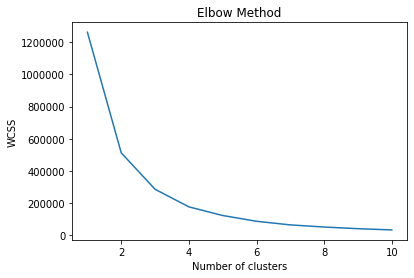

In [204]:
# importing the required module
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

As we can see from the chart above, our elbow point lies at 3. So we will utilise 3 as our number of cluster choice for each of the feature

In [205]:
# Initialising the algorithm
kmeans = KMeans(n_clusters=3)

# Fitting the algorithm for each attribute and then prediecting its cluster
# We will store the cluster numbers in a separate column
kmeans.fit(X[['avg_app_starts']])
X['app_starts_cluster'] = kmeans.predict(X[['avg_app_starts']])

kmeans.fit(X[['avg_geo']])
X['geo_cluster'] = kmeans.predict(X[['avg_geo']])

kmeans.fit(X[['avg_local']])
X['local_cluster'] = kmeans.predict(X[['avg_local']])

kmeans.fit(X[['avg_watcher']])
X['watcher_cluster'] = kmeans.predict(X[['avg_watcher']])

X

,avg_app_starts,avg_geo,avg_local,avg_watcher,app_starts_cluster,geo_cluster,local_cluster,watcher_cluster
user_id,,,,,,,,
000003D9-2B16-4769-90DA-7229244C7A2B,0.250,0.0,0.000000,0.000000,0,0,0,1
0000C5D6-F280-465B-B045-8F34E0792A1F,2.000,0.0,0.032407,0.022727,0,0,1,0
000145B8-94C5-4895-AF17-B3F1F5115A1D,0.000,0.0,0.000000,0.000000,0,0,0,1
00019DB6-D2D9-4510-9623-D40B599148EA,0.250,0.0,0.000000,0.000000,0,0,0,1
00024F5F-3586-4475-B516-8D547577682B,15.375,0.0,0.072115,0.075000,1,0,2,2
...,...,...,...,...,...,...,...,...
FFFC24CB-C572-47F9-A27C-E9F79A9A4606,1.750,0.0,0.019231,0.012255,0,0,1,1
FFFDA685-DCA6-41E9-8715-0F064C4FD702,1.500,0.0,0.000000,0.002976,0,0,0,1
FFFDEEDC-D756-4499-852F-E1FC9ACE424E,0.500,0.0,0.005208,0.000000,0,0,0,1


## Remapping the cluster numbering appropriately

Since k-means will provide us with unordered cluster numbering, we will check each cluster and its properties. We will remap the cluster number wherever necessary using the map function. The aim is to allot a higher cluster number to users who have a higher activity per attribute. So, higher cluster number will mean that a particular user is highly active with regards to that attribute through the app.

In [206]:
# generating descriptive statistics for each cluster to check the cluster numbering logic
X.groupby('app_starts_cluster')['avg_app_starts'].describe()

,count,mean,std,min,25%,50%,75%,max
app_starts_cluster,,,,,,,,
0,72065.0,0.850390,0.971716,0.000,0.125,0.500,1.375,3.750
1,1699.0,20.421866,8.957975,13.625,15.125,17.375,22.250,121.875
2,13250.0,6.807340,2.478350,3.875,4.750,6.125,8.375,13.500


In [207]:
# Remapping unordered cluster numberirng to ordered set of values
X['app_starts_cluster'] = X.app_starts_cluster.map({0:0,1:2,2:1})
X.groupby('app_starts_cluster')[['avg_app_starts']].describe()

avg_app_starts                                       \
                            count       mean       std     min     25%   
app_starts_cluster                                                       
0                         72065.0   0.850390  0.971716   0.000   0.125   
1                         13250.0   6.807340  2.478350   3.875   4.750   
2                          1699.0  20.421866  8.957975  13.625  15.125   

                                             
                       50%     75%      max  
app_starts_cluster                           
0                    0.500   1.375    3.750  
1                    6.125   8.375   13.500  
2                   17.375  22.250  121.875

In [208]:
X.groupby('geo_cluster')[['avg_geo']].describe()

avg_geo                                                       \
               count      mean       std     min     25%       50%    75%   
geo_cluster                                                                 
0            85819.0  0.000281  0.003019  0.0000  0.0000  0.000000  0.000   
1              146.0  0.269991  0.079276  0.1875  0.2500  0.250000  0.250   
2             1049.0  0.094484  0.030571  0.0500  0.0625  0.090909  0.125   

                       
                  max  
geo_cluster            
0            0.046875  
1            0.750000  
2            0.166667

In [209]:
# Remapping unordered cluster numberirng to ordered set of values
X['geo_cluster'] = X.geo_cluster.map({0:0,1:2,2:1})
X.groupby('geo_cluster')[['avg_geo']].describe()

avg_geo                                                       \
               count      mean       std     min     25%       50%    75%   
geo_cluster                                                                 
0            85819.0  0.000281  0.003019  0.0000  0.0000  0.000000  0.000   
1             1049.0  0.094484  0.030571  0.0500  0.0625  0.090909  0.125   
2              146.0  0.269991  0.079276  0.1875  0.2500  0.250000  0.250   

                       
                  max  
geo_cluster            
0            0.046875  
1            0.166667  
2            0.750000

In [210]:
X.groupby('local_cluster')[['avg_local']].describe()

avg_local                                                   \
                  count      mean      std       min       25%       50%   
local_cluster                                                              
0               78310.0  0.000933  0.00261  0.000000  0.000000  0.000000   
1                7354.0  0.025023  0.01052  0.013158  0.016304  0.021739   
2                1350.0  0.082451  0.02387  0.054167  0.062500  0.075000   

                                   
                    75%       max  
local_cluster                      
0              0.000000  0.012931  
1              0.031250  0.053571  
2              0.098214  0.250000

In [211]:
X.groupby('watcher_cluster')[['avg_watcher']].describe()

avg_watcher                                                    \
                      count      mean       std       min       25%       50%   
watcher_cluster                                                                 
0                    6773.0  0.026126  0.010114  0.013636  0.017857  0.023438   
1                   78489.0  0.001126  0.002706  0.000000  0.000000  0.000000   
2                    1752.0  0.076049  0.020374  0.051136  0.060000  0.070890   

                                     
                      75%       max  
watcher_cluster                      
0                0.032895  0.051020  
1                0.000000  0.013587  
2                0.087500  0.125000

In [212]:
# Remapping unordered cluster numberirng to ordered set of values
X['watcher_cluster'] = X.watcher_cluster.map({0:1,1:0,2:2})
X.groupby('watcher_cluster')[['avg_watcher']].describe()

avg_watcher                                                    \
                      count      mean       std       min       25%       50%   
watcher_cluster                                                                 
0                   78489.0  0.001126  0.002706  0.000000  0.000000  0.000000   
1                    6773.0  0.026126  0.010114  0.013636  0.017857  0.023438   
2                    1752.0  0.076049  0.020374  0.051136  0.060000  0.070890   

                                     
                      75%       max  
watcher_cluster                      
0                0.000000  0.013587  
1                0.032895  0.051020  
2                0.087500  0.125000

## Calculating user score for each user based on clustering

The scoring below clearly shows us that customers with score 8 is our best customers whereas 0 is the worst.
To keep things simple, it is better to name these scores:

0 to 2: Low Value
3 to 4: Mid Value
5+: High Value

We can easily apply this naming on our dataframe

In [213]:
# Calculating the user score & summarising the results
X['user_score'] = X['app_starts_cluster'] + X['geo_cluster'] + X['local_cluster'] + X['watcher_cluster']
X.groupby('user_score')[['avg_app_starts','avg_geo','avg_watcher','avg_local']].mean()

,avg_app_starts,avg_geo,avg_watcher,avg_local
user_score,,,,
0,0.745389,0.000104,0.000848,0.000708
1,4.770865,0.002426,0.005471,0.005593
2,7.868261,0.007173,0.017377,0.016006
3,7.362361,0.012040,0.032536,0.028428
4,9.600280,0.023615,0.049784,0.040875
5,10.047003,0.027827,0.071818,0.071098
6,14.931167,0.062227,0.080591,0.087334
7,18.086397,0.121227,0.089061,0.093243
8,14.333333,0.236111,0.109477,0.087908


In [214]:
# creating segments column & assigning the appropriate name to it
X['Segment'] = 'Low-Value'
X.loc[X['user_score']>2,'Segment'] = 'Mid-Value' 
X.loc[X['user_score']>4,'Segment'] = 'High-Value' 

In [237]:
# resetting the index to join the file with the original data for further sharing & analysis if required
X = X.reset_index()
customer = pd.merge(X,df, how = 'inner', on = 'user_id')

In [238]:
# Summarising number of users per segment, per os platform
user_graph = customer.groupby(['user_platform_os','Segment'])['user_id'].nunique().reset_index()
user_graph

,user_platform_os,Segment,user_id
0,android,High-Value,884
1,android,Low-Value,59595
2,android,Mid-Value,2887
3,ios,High-Value,23
4,ios,Low-Value,23365
5,ios,Mid-Value,260


## Insights from past 8 weeks data

We can see from the table above, the number of users for each segment on each OS platform. This overview used the data from the last 8 weeks to categorise each unique users in a segment based on their behavior in using the app. The problem here is that as we already mentioned before, seasonality could be affecting the results.

To solve for this, I will now perform a similar operation but over the lifetime of the user. This would mean creating another user segment called 'lifetime segment' using the total data per user. When we have that data, we will be able to identify recent user trends. This will be highly useful because we can use this information to understand the change in user behaviour and strategise accordingly.

In [239]:
# checking if there are null values in the cluster columns
# If they existed then we could not impute them with 0
# Since there aren't any NaNs in these columns we can impute all NaNs and infinities with 0
customer.loc[:,customer.columns.str.contains('cluster')].isnull().sum()

app_starts_cluster    0
geo_cluster           0
local_cluster         0
watcher_cluster       0
dtype: int64

In [240]:
customer['avg_lifetime_app_starts'] = customer['total_app_starts']/customer.weeks_since_app_downloaded
customer['avg_lifetime_geo'] = (customer['total_geofence_pushes_opened_lifetime']/customer.total_geofence_pushes_received_lifetime)/customer.weeks_since_app_downloaded
customer['avg_lifetime_local'] = (customer['total_localytics_pushes_opened_lifetime']/customer.total_localytics_pushes_recieved_lifetime)/customer.weeks_since_app_downloaded
customer['avg_lifetime_watcher'] = (customer['total_watcher_pushes_opened_lifetime']/customer.total_watcher_pushes_recieved_lifetime)/customer.weeks_since_app_downloaded


In [231]:
# dropping the categorical column 
#customer = customer.drop('app_start_time',axis=1)

In [241]:
# Imputing NaNs with zero for ease of calculation
#customer = customer.fillna(0)
customer.replace([inf,np.NaN],0, inplace=True)

In [242]:

# Initialising the algorithm
kmeans = KMeans(n_clusters=3)

# Fitting the algorithm for each attribute and then prediecting its cluster
# We will store the cluster numbers in a separate column
kmeans.fit(customer[['avg_lifetime_app_starts']])
customer['lifetime_app_starts_cluster'] = kmeans.predict(customer[['avg_lifetime_app_starts']])

kmeans.fit(customer[['avg_lifetime_geo']])
customer['lifetime_geo_cluster'] = kmeans.predict(customer[['avg_lifetime_geo']])

kmeans.fit(customer[['avg_lifetime_local']])
customer['lifetime_local_cluster'] = kmeans.predict(customer[['avg_lifetime_local']])

kmeans.fit(customer[['avg_lifetime_watcher']])
customer['lifetime_watcher_cluster'] = kmeans.predict(customer[['avg_lifetime_watcher']])

In [243]:
# generating descriptive statistics for each cluster to check the cluster numbering logic
customer.groupby('lifetime_app_starts_cluster')['avg_lifetime_app_starts'].describe()

,count,mean,std,min,25%,50%,75%,max
lifetime_app_starts_cluster,,,,,,,,
0,10862.0,10.257169,5.741125,5.878788,6.983468,8.548482,11.50000,134.333333
1,89136.0,1.514501,1.413062,0.019802,0.416667,1.000000,2.21875,5.877551
2,2.0,431.000000,0.000000,431.000000,431.000000,431.000000,431.00000,431.000000


In [244]:
# Remapping unordered cluster numberirng to ordered set of values
customer['lifetime_app_starts_cluster'] = customer.lifetime_app_starts_cluster.map({0:1,1:0,2:2})
customer.groupby('lifetime_app_starts_cluster')['avg_lifetime_app_starts'].describe()

,count,mean,std,min,25%,50%,75%,max
lifetime_app_starts_cluster,,,,,,,,
0,89136.0,1.514501,1.413062,0.019802,0.416667,1.000000,2.21875,5.877551
1,10862.0,10.257169,5.741125,5.878788,6.983468,8.548482,11.50000,134.333333
2,2.0,431.000000,0.000000,431.000000,431.000000,431.000000,431.00000,431.000000


In [245]:
customer.groupby('lifetime_geo_cluster')['avg_lifetime_geo'].describe()

,count,mean,std,min,25%,50%,75%,max
lifetime_geo_cluster,,,,,,,,
0,98892.0,0.000519,0.002157,0.000000,0.000000,0.00,0.000000,0.023810
1,995.0,0.047130,0.021410,0.024038,0.030303,0.04,0.058824,0.111111
2,113.0,0.178713,0.067605,0.115385,0.128571,0.15,0.200000,0.428571


In [246]:
customer.groupby('lifetime_local_cluster')['avg_lifetime_local'].describe()

,count,mean,std,min,25%,50%,75%,max
lifetime_local_cluster,,,,,,,,
0,98254.0,0.001041,0.002440,0.000000,0.000000,0.000000,0.000825,0.018640
1,1630.0,0.036270,0.017457,0.018692,0.022989,0.030325,0.043478,0.095238
2,116.0,0.154344,0.065179,0.096154,0.111111,0.133974,0.166667,0.333333


In [247]:
customer.groupby('lifetime_watcher_cluster')['avg_lifetime_watcher'].describe()

,count,mean,std,min,25%,50%,75%,max
lifetime_watcher_cluster,,,,,,,,
0,97232.0,0.000964,0.002086,0.000000,0.000000,0.000000,0.000841,0.013528
1,2625.0,0.026111,0.013097,0.013548,0.016667,0.021464,0.031097,0.075000
2,143.0,0.124742,0.057689,0.076923,0.089804,0.102564,0.137879,0.375000


In [248]:
# Calculating the lifetime user score & summarising the results
customer['lifetime_user_score'] = customer['lifetime_app_starts_cluster'] + customer['lifetime_geo_cluster'] + customer['lifetime_local_cluster'] + customer['lifetime_watcher_cluster']
customer.groupby('lifetime_user_score')[['avg_lifetime_app_starts','avg_lifetime_geo','avg_lifetime_watcher','avg_lifetime_local']].mean()

,avg_lifetime_app_starts,avg_lifetime_geo,avg_lifetime_watcher,avg_lifetime_local
lifetime_user_score,,,,
0,1.479173,0.000436,0.000792,0.000812
1,8.712292,0.003156,0.004175,0.003745
2,6.913026,0.016702,0.023567,0.024406
3,9.577693,0.019608,0.036492,0.037364
4,14.280515,0.050133,0.052430,0.055659
5,11.833108,0.062052,0.104162,0.115472
6,12.389286,0.166071,0.088079,0.103160
7,19.821429,0.196429,0.088596,0.107143


In [249]:
# creating segments column & assigning the appropriate name to it
customer['lifetime_segment'] = 'Low-Value'
customer.loc[customer['lifetime_user_score']>2,'lifetime_segment'] = 'Mid-Value' 
customer.loc[customer['lifetime_user_score']>4,'lifetime_segment'] = 'High-Value'

In [255]:
customer = customer.drop('index',axis=1)

In [267]:
# Generating a summary of user segment change in last 8 weeks versus lifetime behaviour
user_graph = customer.groupby(['lifetime_segment','Segment'])['user_id'].nunique().reset_index()
user_graph.columns = ['lifetime segment','8-week segment','Number of users']
user_graph.sort_values(by = 'Number of users',ascending = True)

,lifetime segment,8-week segment,Number of users
1,High-Value,Low-Value,1
2,High-Value,Mid-Value,17
0,High-Value,High-Value,19
7,Mid-Value,Low-Value,143
6,Mid-Value,High-Value,207
8,Mid-Value,Mid-Value,309
3,Low-Value,High-Value,681
5,Low-Value,Mid-Value,2821
4,Low-Value,Low-Value,82816


In [271]:
# Defining a function to create a Sankey chart using plotly

def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [ ]:
# importing relevant modules to create a Sankey chart

import plotly
import chart_studio.plotly as py

fig = genSankey(user_graph,cat_cols=['lifetime_segment','Segment'],value_cols='user_id',title='User segment change in lifetime vs last 8 weeks')
plotly.offline.plot(fig, validate=False)

# Actionable insights & conclusion

## Insights

### Based on last 8 weeks data

The gap between high-value & mid-value users is actually not that high. Assuming that seasonality isn't distorting the results here, a low hanging fruit would be to focus on the mid-value users and figure out a way to convert them into high-value users. The gap between low-value and mid-value users is noticably high.

### Based on lifetime behaviour data vs last 8 weeks

When we compare the lifetime segment per user versus the segment using the last 8 weeks data, we can easily see which users are tending to move towards which segment. We see some good trends i.e. quite a few  users, based on the lifetime data, have been moving upwards to more active segments in the last 8 weeks. Assuming that this is not a seasonality effect, we can build on these trends to keep the app interaction high for these users. We also see the users who are moving in the opposite direction. 

This comparison between lifetime segment and the segment based on last 8 weeks data show us how recent trends in user behaviour have evolved. Using these insights and the summary table above, we could plan targeted activation plan for different types of users.


To better visualise the flow of users from one segment to the other over lifetime vs last 8 weeks, I created a sankey chart which can be viewed in HTML by executing the cell above.

## Conclusion

To improve user interaction the important thing is to target them specifically with the kind of notifications that would directly result in a positive result. To do this we need to know when & who to target. Using the insight from the time bins from the EDA as well as the column most_popular_app_start_hour from the dataset, we know when to target each user. With the knowledge from the segmentation table, we know whom to target.

We can start taking actions with these segmentations. The main strategies are quite clear:

1. High Value: Improve Retention - by focussing on what kind of push notifications are relevant
2. Mid Value: Improve Retention + Increase Frequency - both on favorite notifications & emerging ones
3. Low Value: Increase Frequency - on overall offering by diversifying brochure portfolio & identifying patterns in behavior